In [1]:
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
csv_file = 'covis_db_metadata_report_20190403.csv'

data = pd.read_csv(csv_file)
data['datetime'] = pd.to_datetime(data['datetime'])
data.rename( columns={"# basename" : "basename"}, inplace=True )
print(data.columns)

Index(['basename', 'datetime', 'site', 'mode', 'raw_size', 'gz_size',
       '7z_size'],
      dtype='object')


In [5]:
raw_size = data['raw_size'].sum()

date_min = data['datetime'].min()
date_max = data['datetime'].max()
date_span = date_max - date_min

# Count number with non-zero gz size
gz_files = data[ data['gz_size'] > 0 ]
gz_raw_size = gz_files['raw_size'].sum()
gz_size  = gz_files['gz_size'].sum()

gz_mean_compression = gz_files['gz_size'].sum()/gz_files['raw_size'].sum() 
print("Mean gz compression: %.2f %%" % (gz_mean_compression*100))


print("Total of %d data files spanning %d days from %s to %s" % (len(data.index), date_span.days, \
                                                                date_min.strftime('%Y-%m-%d'), \
                                                                 date_max.strftime('%Y-%m-%d')) )
print("Raw size % 9.2f GB  (%15d bytes)" % (raw_size / 1024**3, raw_size))

raw_null_files = data[ pd.isnull(data['raw_size']) ]
zip_null_files = data[ pd.isnull(data['7z_size']) ]
print("")
print("%d files with no reported raw size" % len(raw_null_files))
print("%d files with no reported 7z size" % len(zip_null_files))

print("")
print("%d files with reported .gz size (only files from Ashes which are posted to S3 bucket)" % len(gz_files))
print("gz size  % 9.2f GB  (%15d bytes) mean compression %.2f pct" % ( gz_size / 1024**3,  gz_size, 100*gz_size/gz_raw_size))




zip_files = data[ data['7z_size'] > 0]
zip_size = zip_files['7z_size'].sum()
zip_raw_size = zip_files['raw_size'].sum()

print("")
print("%d files with reported .7z size" % len(zip_files))
print("7z size  % 9.2f GB  (%15d bytes) mean compression %.2f pct" % (zip_size / 1024**3, zip_size, 100*zip_size/zip_raw_size))


print("")
print("%d entries in database which aren't in the 7z archive:" % len(zip_null_files))
print(zip_null_files['basename'])

Mean gz compression: 29.58 %
Total of 54805 data files spanning 3107 days from 2010-09-30 to 2019-04-03
Raw size  119597.81 GB  (128417169874498 bytes)

466 files with no reported raw size
14 files with no reported 7z size

7390 files with reported .gz size (only files from Ashes which are posted to S3 bucket)
gz size    1649.32 GB  (  1770944963473 bytes) mean compression 29.58 pct

54791 files with reported .7z size
7z size   21072.46 GB  ( 22626380108407 bytes) mean compression 17.62 pct

14 entries in database which aren't in the 7z archive:
4405     APLUWCOVISMBSONAR001_20111002T001157.593Z-DOPPLER
4406     APLUWCOVISMBSONAR001_20111003T001156.606Z-DOPPLER
4407     APLUWCOVISMBSONAR001_20111003T061155.528Z-DOPPLER
4408     APLUWCOVISMBSONAR001_20111004T003551.745Z-DOPPLER
4409     APLUWCOVISMBSONAR001_20111004T063549.504Z-DOPPLER
4410     APLUWCOVISMBSONAR001_20111005T001156.667Z-DOPPLER
4411     APLUWCOVISMBSONAR001_20111005T061159.035Z-DOPPLER
18792    APLUWCOVISMBSONAR001_20130

In [6]:
ashes = data[ data['site'] =='Ashes' ]
endeavour = data[ data['site'] == 'Endeavour']

print("Of those, %d are from Ashes, %d from Endeavor" % (len(ashes), len(endeavour)))
print("Ashes raw size of %.2f TB" % (ashes['raw_size'].sum() / 1024**4))
print("Ashes gz  size of %.2f TB" % (ashes['gz_size'].sum() / 1024**4))
print("Ashes 7z  size of %.2f TB" % (ashes['7z_size'].sum() / 1024**4))

print("Endeavour raw size of %.2f TB" % (endeavour['raw_size'].sum() / 1024**4))
print("Endeavour gz  size of %.2f TB" % (endeavour['raw_size'].sum() * gz_mean_compression / 1024**4))
print("Endeavour 7z  size of %.2f TB" % (endeavour['7z_size'].sum() / 1024**4))

Of those, 7390 are from Ashes, 47415 from Endeavor
Ashes raw size of 5.45 TB
Ashes gz  size of 1.61 TB
Ashes 7z  size of 1.00 TB
Endeavour raw size of 111.35 TB
Endeavour gz  size of 32.93 TB
Endeavour 7z  size of 19.58 TB


In [7]:
##  Create a "simplified mode" column

squash = { 'diffuse': re.compile('diffuse*', flags=re.IGNORECASE),
            'doppler': re.compile('doppler*', flags=re.IGNORECASE),
             'imaging': re.compile('imag*', flags=re.IGNORECASE),
             'bathy':  re.compile('bathy*', flags=re.IGNORECASE),
             'survey':  re.compile('survey*', flags=re.IGNORECASE),
             'pano': re.compile('pano*', flags=re.IGNORECASE)}

def simplify_mode(mode):
    for key,regex in squash.items():
        if regex.match(mode):
            return key

    return mode

data['simple_mode'] = data.apply(lambda row: simplify_mode( row['mode'] ), axis=1 )

print("Simplified modes: %s" % data.simple_mode.unique())

Simplified modes: ['survey' 'imaging' 'diffuse' 'target' 'doppler' 'bathy' 'pano']


In [8]:
dates = {}
types = {}

for index, entry in data.iterrows():
    dates[ entry['datetime'].date() ] = True
        
    if entry.simple_mode not in types:
        types[entry.simple_mode] = 0
        
    types[entry.simple_mode] += 1
    
print("COVIS ran on %d days, averaging %.2f GB per day (as gz)" % (len(dates), (gz_size / (1024**3*len(dates)))))
    
for mode,count in types.items():
    print("%10s : %d" % (mode,count))
    

COVIS ran on 1555 days, averaging 1.06 GB per day (as gz)
    survey : 3
   imaging : 11733
   diffuse : 33045
    target : 18
   doppler : 9984
     bathy : 3
      pano : 19


In [9]:
types = {}
for index, entry in data.iterrows():
    if entry['mode'] not in types:
        types[entry['mode']] = 0
        
    types[entry['mode']] += 1
    
for mode,count in types.items():
    print("%10s : %d" % (mode,count))

   survey1 : 1
   survey2 : 1
   imaging : 1
   diffuse : 9
   survey3 : 1
  diffuse3 : 479
  diffuse2 : 515
  diffuse1 : 480
    target : 18
  imaging1 : 177
  imaging2 : 180
  imaging3 : 184
  doppler1 : 1
  doppler2 : 97
  doppler3 : 1
diffuse2up : 1
diffuse2down : 3
diffuse3down : 1
diffuse1down : 1
    bathy2 : 1
    bathy1 : 1
    bathy3 : 1
diffuse3deep : 213
diffuse1deep : 206
diffuse2deep : 217
diffuse2shallow : 219
diffuse1shallow : 214
diffuse3shallow : 216
   IMAGING : 10185
   DOPPLER : 9885
   DIFFUSE : 27320
DIFFUSESLOW : 25
  panoleft : 8
panocenter : 7
 panoright : 2
diffuseright : 1473
diffuseleft : 1453
 panoleft2 : 1
panoright2 : 1
 imageleft : 503
imagecenter : 503


In [11]:
## Calculate mean counts and size per day

by_date = data.set_index('datetime')
by_day = by_date.resample('D').sum()
by_day['count'] = by_date.basename.resample('D').count()
by_day = by_day[ by_day['count'] > 0 ]

print(by_day)

## by_day is now the _total_ amount of data produced per day

## by_month is the _mean daily_ data
by_month = by_day.resample('M').mean()

def estimate_gz(row):
    if row.gz_size == 0.0:
        return gz_mean_compression*row.raw_size
    
    return 0.0
    
by_month['estimated_gz_size'] = by_month.apply(lambda row: estimate_gz( row ), axis=1 )
by_day['estimated_gz_size'] = by_day.apply(lambda row: estimate_gz( row ), axis=1 )



                raw_size       gz_size       7z_size  count
datetime                                                   
2010-09-30  4.763727e+09  0.000000e+00  5.020949e+08      5
2010-10-01  3.435868e+10  0.000000e+00  3.637471e+09     25
2010-10-03  2.820403e+10  0.000000e+00  3.029009e+09     20
2010-10-04  2.829030e+10  0.000000e+00  3.053333e+09     20
2010-10-05  1.664281e+10  0.000000e+00  1.751959e+09     15
2010-10-06  5.549547e+10  0.000000e+00  5.535275e+09     24
2010-10-07  1.387387e+10  0.000000e+00  1.371228e+09      7
2010-10-09  6.617524e+10  0.000000e+00  6.797956e+09     40
2010-10-10  1.102110e+11  0.000000e+00  1.094398e+10     48
2010-10-11  1.109909e+11  0.000000e+00  1.104604e+10     48
2010-10-12  1.109898e+11  0.000000e+00  1.106206e+10     48
2010-10-13  1.109909e+11  0.000000e+00  1.113852e+10     48
2010-10-14  1.109874e+11  0.000000e+00  1.111832e+10     48
2010-10-15  1.109898e+11  0.000000e+00  1.118355e+10     48
2010-10-16  1.109898e+11  0.000000e+00  

/Users/aaron/miniconda3/envs/covis/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


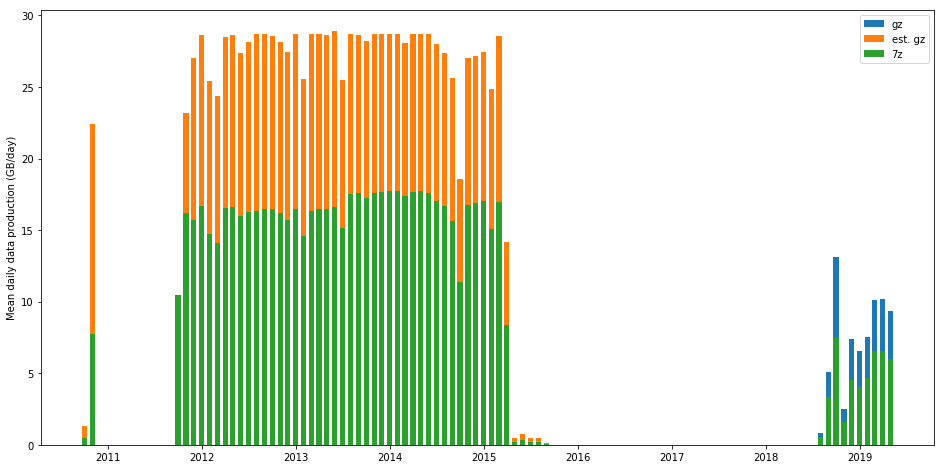

In [12]:
plt.figure( figsize=(16,8))
yscalar = 1.0 / 1024**3
plt.bar( by_month.index, by_month.gz_size * yscalar, width=20, label='gz' )
plt.bar( by_month.index, by_month.estimated_gz_size * yscalar, width=20, label='est. gz' )
plt.bar( by_month.index, by_month['7z_size'] * yscalar, width=20, label='7z' )


plt.ylabel('Mean daily data production (GB/day)')
plt.legend()

plt.show()

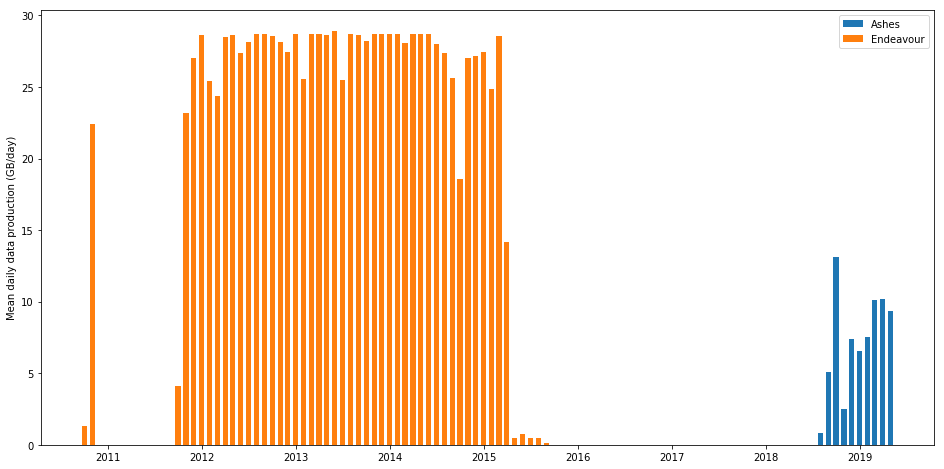

In [13]:
plt.figure( figsize=(16,8))
yscalar = 1.0 / 1024**3
plt.bar( by_month.index, by_month.gz_size * yscalar, width=20, label='Ashes' )
plt.bar( by_month.index, by_month.estimated_gz_size * yscalar, width=20, label='Endeavour' )


plt.ylabel('Mean daily data production (GB/day)')
plt.legend()

plt.show()

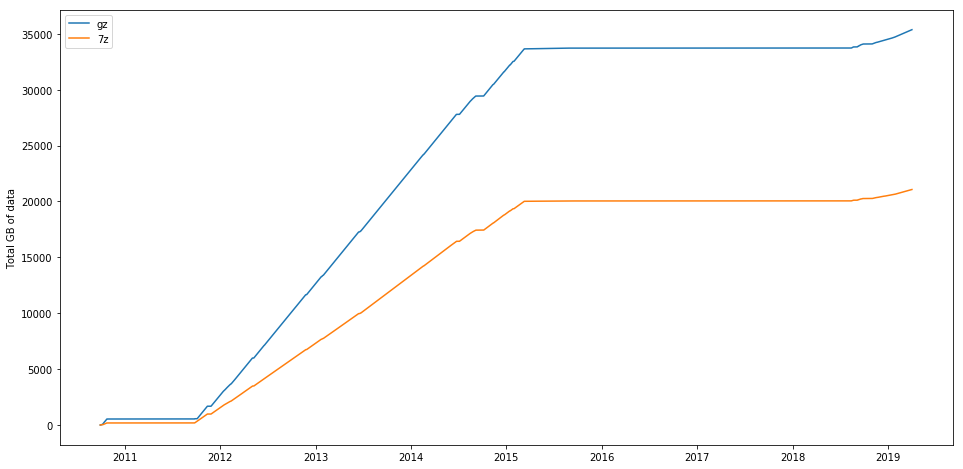

                raw_size       gz_size       7z_size  count  \
datetime                                                      
2010-09-30  4.763727e+09  0.000000e+00  5.020949e+08      5   
2010-10-01  3.435868e+10  0.000000e+00  3.637471e+09     25   
2010-10-02  0.000000e+00  0.000000e+00  0.000000e+00      0   
2010-10-03  2.820403e+10  0.000000e+00  3.029009e+09     20   
2010-10-04  2.829030e+10  0.000000e+00  3.053333e+09     20   
2010-10-05  1.664281e+10  0.000000e+00  1.751959e+09     15   
2010-10-06  5.549547e+10  0.000000e+00  5.535275e+09     24   
2010-10-07  1.387387e+10  0.000000e+00  1.371228e+09      7   
2010-10-08  0.000000e+00  0.000000e+00  0.000000e+00      0   
2010-10-09  6.617524e+10  0.000000e+00  6.797956e+09     40   
2010-10-10  1.102110e+11  0.000000e+00  1.094398e+10     48   
2010-10-11  1.109909e+11  0.000000e+00  1.104604e+10     48   
2010-10-12  1.109898e+11  0.000000e+00  1.106206e+10     48   
2010-10-13  1.109909e+11  0.000000e+00  1.113852e+10   

In [160]:

by_day['gz_total'] = by_day['gz_size'] + by_day['estimated_gz_size']

by_day['raw_accumulated'] = by_day['raw_size'].cumsum()
by_day['gz_accumulated'] = by_day['gz_total'].cumsum()
by_day['7z_accumulated'] = by_day['7z_size'].cumsum()


plt.figure( figsize=(16,8) )
plt.plot( by_day.index, by_day.gz_accumulated * yscalar, label='gz' )
plt.plot( by_day.index, by_day['7z_accumulated'] * yscalar , label='7z' )

plt.ylabel('Total GB of data')
plt.legend()
plt.show()

print(by_day)


['Ashes' 'Endeavour']


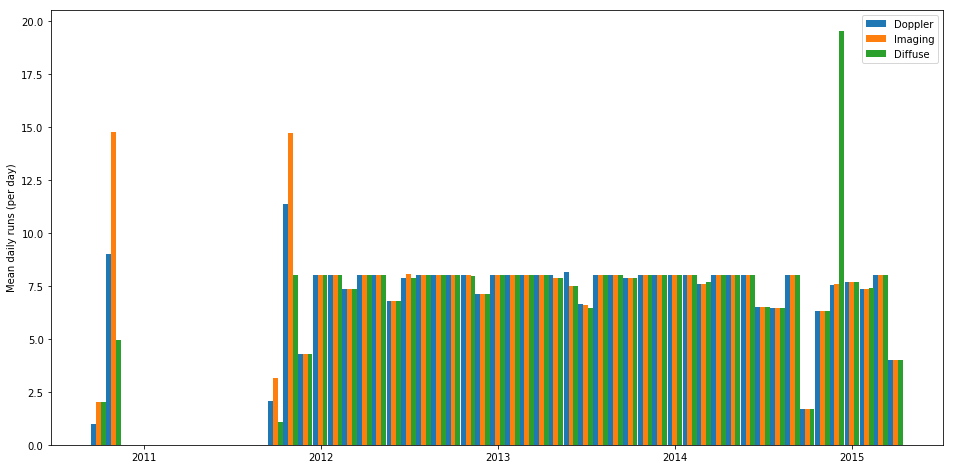

In [44]:
## Select only the Endeavour data

print( data.site.unique() )

endeavour = data[ data['site']=='Endeavour']
enddate = endeavour.set_index('datetime')

## count simplified modes
endimg = enddate[ enddate['simple_mode'] == 'imaging']
enddop = enddate[ enddate['simple_mode'] == 'doppler']
enddif = enddate[ enddate['simple_mode'] == 'diffuse']

perday = pd.DataFrame()
perday['doppler'] = enddop.basename.resample('D').count()
perday['imaging'] = endimg.basename.resample('D').count()
perday['diffuse'] = enddif.basename.resample('D').count()



# endimgday = endimgday[ endimgday > 0 ]

## by_day is now the _total_ amount of data produced per day

## by_month is the _mean daily_ data
permonth = perday.resample('M').mean()


plt.figure( figsize=(16,8))

plt.bar( permonth.index.shift(-10, freq='D'), permonth.doppler, width=10, label='Doppler' )
plt.bar( permonth.index, permonth.imaging, width=10, label='Imaging' )
plt.bar( permonth.index.shift(10, freq='D'), permonth.diffuse, width=10, label='Diffuse' )

plt.ylabel('Mean daily runs (per day)')
plt.legend()

plt.show()
